In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import lstsq
from scipy.interpolate import interp1d, LinearNDInterpolator, NearestNDInterpolator
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb 
from sklearn.model_selection import train_test_split as tts

import lightgbm as lgbm
import time


c:\Users\mnelk\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Tricubic Kernel, Lowess, and general Boosting definitions

def Tricubic(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,70/81*(1-d**3)**3)

def lw_reg(X, y, xnew, kern, tau, intercept):
    # tau is called bandwidth K((x-x[i])/(2*tau))
    n = len(X) # the number of observations
    yest = np.zeros(n)

    if len(y.shape)==1: # here we make column vectors
      y = y.reshape(-1,1)
    if len(X.shape)==1:
      X = X.reshape(-1,1)
    if intercept:
      X1 = np.column_stack([np.ones((len(X),1)),X])
    else:
      X1 = X

    w = np.array([kern((X - X[i])/(2*tau)) for i in range(n)]) # here we compute n vectors of weights

    #Looping through all X-points, solving for the predictions as linear combinations of inputs and weights matrix
    for i in range(n):          
        W = np.diag(w[:,i])
        b = np.transpose(X1).dot(W).dot(y)
        A = np.transpose(X1).dot(W).dot(X1)
        #A = A + 0.001*np.eye(X1.shape[1]) # if we want L2 regularization
        #theta = linalg.solve(A, b) # A*theta = b
        beta, res, rnk, s = lstsq(A, b)
        yest[i] = np.dot(X1[i],beta)
    if X.shape[1]==1:
      f = interp1d(X.flatten(),yest,fill_value='extrapolate')
    else:
      f = LinearNDInterpolator(X, yest)
    output = f(xnew) # the output may have NaN's where the data points from xnew are outside the convex hull of X
    if sum(np.isnan(output))>0:
      g = NearestNDInterpolator(X,y.ravel()) 
      # output[np.isnan(output)] = g(X[np.isnan(output)])
      output[np.isnan(output)] = g(xnew[np.isnan(output)])
    return output  

def rep_boosted_lwr(X, y, xtest, kern, tau, booster, nboost, intercept):
  yhat = lw_reg(X,y,X,kern,tau,intercept) #get loess predictions on training data
  yhat_test = lw_reg(X,y,xtest,kern,tau,intercept) #get loess predictions on testing data
  lw_error = y - yhat #find the loess training residuals; these are what the booster will train on
  #Below, fit the booster on train data and residuals, then add its predictions to the train/test predictions, then get new residuals
  for i in range(nboost): 
    booster.fit(X, lw_error)
    yhat += booster.predict(X)
    yhat_test += booster.predict(xtest)
    lw_error = y - yhat
  return yhat_test

def n_boost(X, y, xtest, model, nboost, booster, kern = None, tau = None, tau_b = None, 
            intercept = None, n_estimators=None , max_depth=None, model_nn = None):
  if booster == 'LWR':
    if model == 'LWR':
      yhat = lw_reg(X,y,X,kern,tau,intercept) #get loess predictions on training data
      yhat_test = lw_reg(X,y,xtest,kern,tau,intercept) #get loess predictions on testing data
      lw_error = y - yhat #find the loess training residuals; these are what the booster will train on
      for i in range(nboost): 
        yhat += lw_reg(X,lw_error,X,kern,tau_b,intercept)
        yhat_test += lw_reg(X,lw_error,xtest,kern,tau_b,intercept)
        lw_error = y - yhat
      return yhat_test

    if model == 'RF' or model == 'RFR':
      model_rf = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth)
      model_rf.fit(X,y)
      yhat_rf = model_rf.predict(X)
      yhat_test = model_rf.predict(xtest)
      rf_error = y - yhat_rf
      for i in range(nboost): 
        yhat_rf += lw_reg(X,rf_error,X,kern,tau_b,intercept)
        yhat_test += lw_reg(X,rf_error,xtest,kern,tau_b,intercept)
        rf_error = y - yhat_rf
      return yhat_test

    if model == 'NN':
      model_nn.fit(X,y,validation_split=0.3, epochs=100, batch_size=20, verbose=0, callbacks=[es])
      yhat_nn = model_nn.predict(X)
      yhat_test = model_nn.predict(xtest)
      nn_error = y - yhat_nn
      for i in range(nboost): 
        yhat_nn += lw_reg(X,nn_error,X,kern,tau_b,intercept)
        yhat_test += lw_reg(X,nn_error,xtest,kern,tau_b,intercept)
        nn_error = y-yhat_nn
      return yhat_test

  else:
    if model == 'LWR':
      yhat = lw_reg(X,y,X,kern,tau,intercept) #get loess predictions on training data
      yhat_test = lw_reg(X,y,xtest,kern,tau,intercept) #get loess predictions on testing data
      lw_error = y - yhat #find the loess training residuals; these are what the booster will train on
      for i in range(nboost): 
        booster.fit(X, lw_error)
        yhat += booster.predict(X)
        yhat_test += booster.predict(xtest)
        lw_error = y - yhat
      return yhat_test

    if model == 'RF' or model == 'RFR':
      model_rf = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth)
      model_rf.fit(X,y)
      yhat_rf = model_rf.predict(X)
      yhat_test = model_rf.predict(xtest)
      rf_error = y - yhat_rf
      for i in range(nboost): 
        booster.fit(X, rf_error)
        yhat_rf += booster.predict(X)
        yhat_test += booster.predict(xtest)
        rf_error = y - yhat_rf
      return yhat_test

    if model == 'NN':
      model_nn.fit(X,y,validation_split=0.3, epochs=100, batch_size=20, verbose=0, callbacks=[es])
      yhat_nn = model_nn.predict(X)
      yhat_test = model_nn.predict(xtest)
      nn_error = y - yhat_nn
      for i in range(nboost): 
        booster.fit(X, nn_error)
        yhat_nn += booster.predict(X)
        yhat_test += booster.predict(xtest)
        nn_error = y - yhat_nn
      return yhat_test

In [3]:
url = "https://github.com/MichaelCusackNelkin/WM_DATA410/blob/main/Projects/Data/Concrete_Data.csv?raw=true"
data = pd.read_csv(url)
data = np.concatenate([data[data.columns[0:8]].values, data[data.columns[-1]].values.reshape(-1,1)], axis=1)
print(data.shape)
data[0]

(1030, 9)


array([ 540.  ,    0.  ,    0.  ,  162.  ,    2.5 , 1040.  ,  676.  ,
         28.  ,   79.99])

In [4]:
#Cross-Validation
mse_lwr_d = []
mse_lwr_rf = []
mse_rf_d = []
mse_lwr_lwr = []
mse_lgbm = []

scale = StandardScaler()
for i in range(12345,12347):
  print('Random State: ' + str(i))
  kf = KFold(n_splits=5,shuffle=True,random_state=i)
  # this is the random state cross-validation loop to make sure our results are real, not just the state being good/bad for a particular model
  j = 0
  for idxtrain, idxtest in kf.split(data[:,:2]):
    t = time.time()
    j += 1
    #Split the train and test data
    xtrain = data[:,:6][idxtrain]
    ytrain = data[:,-1][idxtrain]
    ytest = data[:,-1][idxtest]
    xtest = data[:,:6][idxtest]
    xtrain = scale.fit_transform(xtrain)
    xtest = scale.transform(xtest)


    #LWR boosted with decision tree
    booster = DecisionTreeRegressor(max_depth=2)
    yhat_lwr_d = n_boost(xtrain, ytrain, xtest, model = 'LWR', nboost=3, booster=booster, 
                   kern = Tricubic, tau = 1.2, intercept = True,)
    
    #LWR boosted with RF
    booster = RandomForestRegressor(n_estimators=25, max_depth=2)
    yhat_lwr_rf = n_boost(xtrain, ytrain, xtest, model = 'LWR', nboost=3, booster=booster, 
                   kern = Tricubic, tau = 1.2, intercept = True)

    #LWR boosted with LWR
    booster='LWR'
    yhat_lwr_lwr = n_boost(xtrain, ytrain, xtest, model = 'LWR', nboost=3, booster=booster, 
                   kern = Tricubic, tau = 1.2, tau_b=0.5, intercept = True)
    
    #RF boosted with decision tree
    booster = DecisionTreeRegressor(max_depth=2)
    yhat_rf_d = n_boost(xtrain, ytrain, xtest, model = 'RFR', nboost=3, booster=booster, n_estimators=100 , max_depth=3)
    
    #RF boosted with LWR
    booster = 'LWR'
    yhat_rf_d = n_boost(xtrain, ytrain, xtest, model = 'RFR', nboost=3, booster=booster, 
                   kern = Tricubic, tau = 1.2, tau_b=0.5, intercept = True, n_estimators=100 , max_depth=3)

    #LightGBM
    lgb = lgbm.LGBMRegressor(num_iterations=1000)
    lgb.fit(xtrain, ytrain, eval_set=[(xtest, ytest)], eval_metric='mse', early_stopping_rounds=100)
    yhat_lgbm = lgb.predict(xtest, num_iteration=lgb.best_iteration_)


    #Append each model's MSE
    mse_lwr_lwr.append(mse(ytest,yhat_lwr_lwr))
    mse_lwr_d.append(mse(ytest,yhat_lwr_d))
    mse_lwr_rf.append(mse(ytest,yhat_lwr_rf))
    mse_rf_d.append(mse(ytest,yhat_rf_d))
    mse_lgbm.append(mse(ytest,yhat_lgbm))

    dt = time.time() - t
    print(str(np.around(dt/60, 2)) + 'Minutes in Split Number: ' + str(j))



Random State: 12345


C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20

[1]	valid_0's l2: 276.336
[2]	valid_0's l2: 253.786
[3]	valid_0's l2: 236.244
[4]	valid_0's l2: 222.175
[5]	valid_0's l2: 209.345
[6]	valid_0's l2: 199.536
[7]	valid_0's l2: 192.146
[8]	valid_0's l2: 186.716
[9]	valid_0's l2: 181.937
[10]	valid_0's l2: 177.236
[11]	valid_0's l2: 173.852
[12]	valid_0's l2: 172.185
[13]	valid_0's l2: 170.191
[14]	valid_0's l2: 168.389
[15]	valid_0's l2: 166.469
[16]	valid_0's l2: 165.344
[17]	valid_0's l2: 163.923
[18]	valid_0's l2: 162.172
[19]	valid_0's l2: 161.856
[20]	valid_0's l2: 161.088
[21]	valid_0's l2: 160.058
[22]	valid_0's l2: 159.428
[23]	valid_0's l2: 158.874
[24]	valid_0's l2: 158.231
[25]	valid_0's l2: 157.861
[26]	valid_0's l2: 157.142
[27]	valid_0's l2: 156.848
[28]	valid_0's l2: 155.98
[29]	valid_0's l2: 155.995
[30]	valid_0's l2: 155.768
[31]	valid_0's l2: 155.82
[32]	valid_0's l2: 155.602
[33]	valid_0's l2: 155.391
[34]	valid_0's l2: 155.281
[35]	valid_0's l2: 154.952
[36]	valid_0's l2: 154.787
[37]	valid_0's l2: 154.197
[38]	valid_0

C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20

[1]	valid_0's l2: 251.178
[2]	valid_0's l2: 231.882
[3]	valid_0's l2: 215.571
[4]	valid_0's l2: 201.937
[5]	valid_0's l2: 191.88
[6]	valid_0's l2: 182.731
[7]	valid_0's l2: 174.5
[8]	valid_0's l2: 168.619
[9]	valid_0's l2: 163.783
[10]	valid_0's l2: 159.416
[11]	valid_0's l2: 155.855
[12]	valid_0's l2: 152.871
[13]	valid_0's l2: 151.584
[14]	valid_0's l2: 149.827
[15]	valid_0's l2: 148.905
[16]	valid_0's l2: 147.725
[17]	valid_0's l2: 147.028
[18]	valid_0's l2: 146.799
[19]	valid_0's l2: 146.703
[20]	valid_0's l2: 146.296
[21]	valid_0's l2: 145.389
[22]	valid_0's l2: 145.55
[23]	valid_0's l2: 145.712
[24]	valid_0's l2: 145.542
[25]	valid_0's l2: 146.14
[26]	valid_0's l2: 146.695
[27]	valid_0's l2: 146.534
[28]	valid_0's l2: 147.156
[29]	valid_0's l2: 147.099
[30]	valid_0's l2: 147.017
[31]	valid_0's l2: 147.495
[32]	valid_0's l2: 147.744
[33]	valid_0's l2: 147.787
[34]	valid_0's l2: 147.922
[35]	valid_0's l2: 148.505
[36]	valid_0's l2: 148.867
[37]	valid_0's l2: 149.216
[38]	valid_0's 

C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20

[1]	valid_0's l2: 244.949
[2]	valid_0's l2: 225.047
[3]	valid_0's l2: 210.122
[4]	valid_0's l2: 197.951
[5]	valid_0's l2: 186.898
[6]	valid_0's l2: 178.356
[7]	valid_0's l2: 170.469
[8]	valid_0's l2: 164.772
[9]	valid_0's l2: 159.575
[10]	valid_0's l2: 155.853
[11]	valid_0's l2: 152.424
[12]	valid_0's l2: 149.556
[13]	valid_0's l2: 147.052
[14]	valid_0's l2: 145.787
[15]	valid_0's l2: 143.882
[16]	valid_0's l2: 142.862
[17]	valid_0's l2: 141.823
[18]	valid_0's l2: 140.648
[19]	valid_0's l2: 139.657
[20]	valid_0's l2: 138.848
[21]	valid_0's l2: 139.51
[22]	valid_0's l2: 139.934
[23]	valid_0's l2: 140.744
[24]	valid_0's l2: 140.7
[25]	valid_0's l2: 141.638
[26]	valid_0's l2: 141.039
[27]	valid_0's l2: 140.854
[28]	valid_0's l2: 141.498
[29]	valid_0's l2: 141.84
[30]	valid_0's l2: 141.601
[31]	valid_0's l2: 142.323
[32]	valid_0's l2: 142.643
[33]	valid_0's l2: 142.554
[34]	valid_0's l2: 142.765
[35]	valid_0's l2: 142.471
[36]	valid_0's l2: 142.992
[37]	valid_0's l2: 143.656
[38]	valid_0's

C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20

[1]	valid_0's l2: 249.877
[2]	valid_0's l2: 228.011
[3]	valid_0's l2: 209.78
[4]	valid_0's l2: 195.634
[5]	valid_0's l2: 183.66
[6]	valid_0's l2: 174.128
[7]	valid_0's l2: 165.665
[8]	valid_0's l2: 158.968
[9]	valid_0's l2: 153.488
[10]	valid_0's l2: 149.121
[11]	valid_0's l2: 145.124
[12]	valid_0's l2: 141.758
[13]	valid_0's l2: 139.301
[14]	valid_0's l2: 137.152
[15]	valid_0's l2: 135.173
[16]	valid_0's l2: 133.884
[17]	valid_0's l2: 133.653
[18]	valid_0's l2: 132.531
[19]	valid_0's l2: 132.361
[20]	valid_0's l2: 131.841
[21]	valid_0's l2: 131.857
[22]	valid_0's l2: 131.637
[23]	valid_0's l2: 131.77
[24]	valid_0's l2: 131.83
[25]	valid_0's l2: 131.598
[26]	valid_0's l2: 131.985
[27]	valid_0's l2: 132.356
[28]	valid_0's l2: 132.594
[29]	valid_0's l2: 132.628
[30]	valid_0's l2: 133.013
[31]	valid_0's l2: 133.295
[32]	valid_0's l2: 133.427
[33]	valid_0's l2: 134.039
[34]	valid_0's l2: 133.922
[35]	valid_0's l2: 133.934
[36]	valid_0's l2: 134.033
[37]	valid_0's l2: 134.19
[38]	valid_0's 

C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20

[1]	valid_0's l2: 249.725
[2]	valid_0's l2: 229.015
[3]	valid_0's l2: 211.67
[4]	valid_0's l2: 199.267
[5]	valid_0's l2: 189.466
[6]	valid_0's l2: 181.319
[7]	valid_0's l2: 175.128
[8]	valid_0's l2: 170.262
[9]	valid_0's l2: 165.485
[10]	valid_0's l2: 161.189
[11]	valid_0's l2: 158.402
[12]	valid_0's l2: 156.446
[13]	valid_0's l2: 155.466
[14]	valid_0's l2: 154.218
[15]	valid_0's l2: 154.381
[16]	valid_0's l2: 153.459
[17]	valid_0's l2: 152.877
[18]	valid_0's l2: 153.107
[19]	valid_0's l2: 152.913
[20]	valid_0's l2: 152.898
[21]	valid_0's l2: 153.307
[22]	valid_0's l2: 153.274
[23]	valid_0's l2: 153.565
[24]	valid_0's l2: 153.679
[25]	valid_0's l2: 153.513
[26]	valid_0's l2: 153.817
[27]	valid_0's l2: 154.05
[28]	valid_0's l2: 154.117
[29]	valid_0's l2: 154.47
[30]	valid_0's l2: 154.982
[31]	valid_0's l2: 155.032
[32]	valid_0's l2: 154.925
[33]	valid_0's l2: 155.222
[34]	valid_0's l2: 155.555
[35]	valid_0's l2: 155.844
[36]	valid_0's l2: 155.862
[37]	valid_0's l2: 156.17
[38]	valid_0's

C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20

[1]	valid_0's l2: 283.175
[2]	valid_0's l2: 257.508
[3]	valid_0's l2: 238.885
[4]	valid_0's l2: 221.993
[5]	valid_0's l2: 208.972
[6]	valid_0's l2: 197.848
[7]	valid_0's l2: 188.333
[8]	valid_0's l2: 182.364
[9]	valid_0's l2: 176.708
[10]	valid_0's l2: 172.396
[11]	valid_0's l2: 168.512
[12]	valid_0's l2: 165.253
[13]	valid_0's l2: 163.137
[14]	valid_0's l2: 160.455
[15]	valid_0's l2: 158.915
[16]	valid_0's l2: 157.662
[17]	valid_0's l2: 156.732
[18]	valid_0's l2: 155.615
[19]	valid_0's l2: 154.753
[20]	valid_0's l2: 154.291
[21]	valid_0's l2: 154.605
[22]	valid_0's l2: 153.917
[23]	valid_0's l2: 153.837
[24]	valid_0's l2: 153.898
[25]	valid_0's l2: 154.361
[26]	valid_0's l2: 154.99
[27]	valid_0's l2: 155.225
[28]	valid_0's l2: 155.5
[29]	valid_0's l2: 155.908
[30]	valid_0's l2: 155.994
[31]	valid_0's l2: 156.211
[32]	valid_0's l2: 156.478
[33]	valid_0's l2: 156.43
[34]	valid_0's l2: 156.417
[35]	valid_0's l2: 156.817
[36]	valid_0's l2: 157.17
[37]	valid_0's l2: 157.888
[38]	valid_0's 

C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20

[1]	valid_0's l2: 222.587
[2]	valid_0's l2: 202.032
[3]	valid_0's l2: 185.463
[4]	valid_0's l2: 171.95
[5]	valid_0's l2: 161.351
[6]	valid_0's l2: 152.608
[7]	valid_0's l2: 145.004
[8]	valid_0's l2: 139.496
[9]	valid_0's l2: 134.834
[10]	valid_0's l2: 131.233
[11]	valid_0's l2: 128.176
[12]	valid_0's l2: 125.235
[13]	valid_0's l2: 123.349
[14]	valid_0's l2: 121.877
[15]	valid_0's l2: 121.008
[16]	valid_0's l2: 119.842
[17]	valid_0's l2: 119.019
[18]	valid_0's l2: 118.905
[19]	valid_0's l2: 118.484
[20]	valid_0's l2: 118.237
[21]	valid_0's l2: 117.936
[22]	valid_0's l2: 117.485
[23]	valid_0's l2: 117.252
[24]	valid_0's l2: 117.478
[25]	valid_0's l2: 117.553
[26]	valid_0's l2: 117.704
[27]	valid_0's l2: 117.975
[28]	valid_0's l2: 118.313
[29]	valid_0's l2: 118.707
[30]	valid_0's l2: 119.121
[31]	valid_0's l2: 119.23
[32]	valid_0's l2: 119.221
[33]	valid_0's l2: 119.769
[34]	valid_0's l2: 119.967
[35]	valid_0's l2: 120.114
[36]	valid_0's l2: 120.27
[37]	valid_0's l2: 120.531
[38]	valid_0'

C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20

[1]	valid_0's l2: 262.168
[2]	valid_0's l2: 242.165
[3]	valid_0's l2: 224.731
[4]	valid_0's l2: 210.435
[5]	valid_0's l2: 199.051
[6]	valid_0's l2: 189.435
[7]	valid_0's l2: 182.371
[8]	valid_0's l2: 176.494
[9]	valid_0's l2: 171.355
[10]	valid_0's l2: 167.318
[11]	valid_0's l2: 164.021
[12]	valid_0's l2: 160.009
[13]	valid_0's l2: 157.728
[14]	valid_0's l2: 155.723
[15]	valid_0's l2: 154.552
[16]	valid_0's l2: 152.831
[17]	valid_0's l2: 151.769
[18]	valid_0's l2: 151.542
[19]	valid_0's l2: 151.333
[20]	valid_0's l2: 151.124
[21]	valid_0's l2: 151.19
[22]	valid_0's l2: 150.902
[23]	valid_0's l2: 150.84
[24]	valid_0's l2: 150.877
[25]	valid_0's l2: 150.562
[26]	valid_0's l2: 150.601
[27]	valid_0's l2: 150.458
[28]	valid_0's l2: 150.349
[29]	valid_0's l2: 150.322
[30]	valid_0's l2: 150.34
[31]	valid_0's l2: 150.943
[32]	valid_0's l2: 151.102
[33]	valid_0's l2: 151.338
[34]	valid_0's l2: 151.574
[35]	valid_0's l2: 151.947
[36]	valid_0's l2: 152.043
[37]	valid_0's l2: 152.279
[38]	valid_0'

C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20

[1]	valid_0's l2: 243.875
[2]	valid_0's l2: 224.732
[3]	valid_0's l2: 209.481
[4]	valid_0's l2: 195.853
[5]	valid_0's l2: 185.831
[6]	valid_0's l2: 177.107
[7]	valid_0's l2: 169.9
[8]	valid_0's l2: 163.406
[9]	valid_0's l2: 158.284
[10]	valid_0's l2: 154.675
[11]	valid_0's l2: 151.036
[12]	valid_0's l2: 148.419
[13]	valid_0's l2: 146.516
[14]	valid_0's l2: 145.456
[15]	valid_0's l2: 144.627
[16]	valid_0's l2: 143.294
[17]	valid_0's l2: 142.406
[18]	valid_0's l2: 141.365
[19]	valid_0's l2: 140.522
[20]	valid_0's l2: 140.265
[21]	valid_0's l2: 140.011
[22]	valid_0's l2: 139.595
[23]	valid_0's l2: 139.579
[24]	valid_0's l2: 139.982
[25]	valid_0's l2: 139.856
[26]	valid_0's l2: 139.947
[27]	valid_0's l2: 139.828
[28]	valid_0's l2: 140.016
[29]	valid_0's l2: 140.074
[30]	valid_0's l2: 140.536
[31]	valid_0's l2: 140.851
[32]	valid_0's l2: 140.927
[33]	valid_0's l2: 141.127
[34]	valid_0's l2: 141.355
[35]	valid_0's l2: 141.763
[36]	valid_0's l2: 141.802
[37]	valid_0's l2: 142.138
[38]	valid_0

C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20600/40640258.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yest[i] = np.dot(X1[i],beta)
C:\Users\mnelk\AppData\Local\Temp/ipykernel_20

[1]	valid_0's l2: 256.754
[2]	valid_0's l2: 234.159
[3]	valid_0's l2: 217.332
[4]	valid_0's l2: 203.172
[5]	valid_0's l2: 191.39
[6]	valid_0's l2: 182.134
[7]	valid_0's l2: 175.245
[8]	valid_0's l2: 169.427
[9]	valid_0's l2: 164.988
[10]	valid_0's l2: 161.225
[11]	valid_0's l2: 157.715
[12]	valid_0's l2: 154.941
[13]	valid_0's l2: 152.888
[14]	valid_0's l2: 150.986
[15]	valid_0's l2: 149.857
[16]	valid_0's l2: 149.501
[17]	valid_0's l2: 148.575
[18]	valid_0's l2: 147.917
[19]	valid_0's l2: 146.86
[20]	valid_0's l2: 146.634
[21]	valid_0's l2: 146.084
[22]	valid_0's l2: 145.582
[23]	valid_0's l2: 145.724
[24]	valid_0's l2: 146.09
[25]	valid_0's l2: 145.828
[26]	valid_0's l2: 146.134
[27]	valid_0's l2: 146.128
[28]	valid_0's l2: 146.222
[29]	valid_0's l2: 146.399
[30]	valid_0's l2: 146.485
[31]	valid_0's l2: 147.181
[32]	valid_0's l2: 147.569
[33]	valid_0's l2: 147.806
[34]	valid_0's l2: 148.306
[35]	valid_0's l2: 148.416
[36]	valid_0's l2: 148.428
[37]	valid_0's l2: 148.43
[38]	valid_0's

In [5]:
print('\n The Results for the Concrete Compressive Strength Dataset were:')
print('The Cross-validated Mean Squared Error for LWR with Decision Tree is : '+str(np.mean(mse_lwr_d)))
print('The Cross-validated Mean Squared Error for LWR with Random Forest is : '+str(np.mean(mse_lwr_rf)))
print('The Cross-validated Mean Squared Error for Random Forest with Decision Tree is : '+str(np.mean(mse_rf_d)))
print('The Cross-validated Mean Squared Error for LWR with LWR : '+str(np.mean(mse_lwr_lwr)))
print('The Cross-validated Mean Squared Error for LightGBM : '+str(np.mean(mse_lgbm)))


 The Results for the Concrete Compressive Strength Dataset were:
The Cross-validated Mean Squared Error for LWR with Decision Tree is : 143.0124214079081
The Cross-validated Mean Squared Error for LWR with Random Forest is : 140.1396167119828
The Cross-validated Mean Squared Error for Random Forest with Decision Tree is : 181.41661702391986
The Cross-validated Mean Squared Error for LWR with LWR : 199.80074228817875
The Cross-validated Mean Squared Error for LightGBM : 142.94194351131054


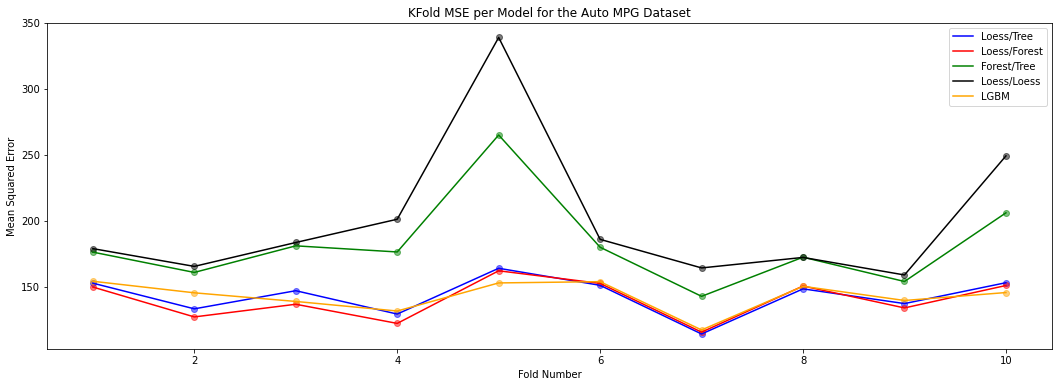

In [6]:
fig, ax = plt.subplots(figsize=(18,6))

#Cars Plot
ax.plot(np.arange(1,11,1),mse_lwr_d, color='blue', label='Loess/Tree')
ax.plot(np.arange(1,11,1),mse_lwr_rf, color='red', label='Loess/Forest')
ax.plot(np.arange(1,11,1),mse_rf_d, color='green', label='Forest/Tree')
ax.plot(np.arange(1,11,1),mse_lwr_lwr, color='black', label='Loess/Loess')
ax.plot(np.arange(1,11,1),mse_lgbm, color='orange', label='LGBM')

ax.scatter(np.arange(1,11,1),mse_lwr_d, color='blue', alpha=0.5)
ax.scatter(np.arange(1,11,1),mse_lwr_rf, color='red', alpha=0.5)
ax.scatter(np.arange(1,11,1),mse_rf_d, color='green', alpha=0.5)
ax.scatter(np.arange(1,11,1),mse_lwr_lwr, color='black', alpha=0.5)
ax.scatter(np.arange(1,11,1),mse_lgbm, color='orange', alpha=0.5)

#ax.axhline(y=np.mean(mse_lwr_d), xmin=0, xmax = 1, color='red',label='Avg. Loess MSE', alpha=0.3)
#ax.axhline(y=np.mean(mse_lwr_rf), xmin=0, xmax=1, color='blue', label='Avg. Boosted Loess MSE', alpha=0.3)
#ax.axhline(y=np.mean(mse_rf_d), xmin=0, xmax = 1, color='green',label='Avg. Random Forest MSE', alpha=0.3)
#ax.axhline(y=np.mean(mse_lwr_lwr), xmin=0, xmax = 1, color='black',label='Avg. XGB MSE', alpha=0.3)
#ax.axhline(y=np.mean(mse_lgbm), xmin=0, xmax = 1, color='orange',label='Avg. XGB MSE', alpha=0.3)


ax.set(xlabel='Fold Number', ylabel = 'Mean Squared Error')
ax.set_title('KFold MSE per Model for the Auto MPG Dataset')
ax.legend()